In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import tarfile
import numpy as np
from urllib import request

import tensorflow as tf

from shutil import copyfile


base_path = "dataset"

if not os.path.isdir(base_path):
  os.makedirs(base_path)


dataset_tar_path = os.path.join(base_path,"vgg_face_dataset.tar.gz")

if not os.path.isfile(dataset_tar_path):
  vgg_face_dataset_url = "http://www.robots.ox.ac.uk/~vgg/data/vgg_face/vgg_face_dataset.tar.gz"
  
  with request.urlopen(vgg_face_dataset_url) as r, open(os.path.join(base_path, "vgg_face_dataset.tar.gz"), 'wb') as f:
    f.write(r.read())

  with tarfile.open(os.path.join(base_path, "vgg_face_dataset.tar.gz")) as f:
    f.extractall(os.path.join(base_path))

# check if the haarcascade file exists
if not os.path.isfile(os.path.join(base_path, "haarcascade_frontalface_default.xml")):
  
  trained_haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

  with request.urlopen(trained_haarcascade_url) as r, open(os.path.join(base_path, "haarcascade_frontalface_default.xml"), 'wb') as f:
      f.write(r.read())




In [2]:
def display_images(image,labels=np.array([])):
    for img in image:
        # plt.figure(figsize=(1, 1))
        #   plt.subplot(1, len(images), i + 1)
        try:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            # plt.imshow(img)
            plt.axis("off")
            plt.show()
        except:
            pass


def get_celeb_txt_file(celeb_name):
    return [subject for subject in sorted(os.listdir(os.path.join(base_path, "vgg_face_dataset", "files"))) if subject.startswith(celeb_name) and subject.endswith(".txt")]


def get_images(subject, nb_images):
    with open(os.path.join(base_path, "vgg_face_dataset", "files", subject), 'r') as f:
        lines = f.readlines()

    images_ = []
    for line in lines:
        url = line[line.find("http://"): line.find(".jpg") + 4]
        try:
            res = request.urlopen(url,timeout=5)
            img = np.asarray(bytearray(res.read()), dtype="uint8")
            img = cv2.imdecode(img, cv2.IMREAD_COLOR)
            images_.append(img)
        except:
            pass

        if len(images_) == nb_images:
            break

    print("Number of images found: ", len(images_))
    return images_


def save_images_to_path(images, folder_path, person_name):
    os.makedirs(folder_path, exist_ok=True)

    for i, img in enumerate(images):
        try:
            # Create a unique filename for each image
            image_path = os.path.join(folder_path, f"{person_name}_{i}.jpg")

            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.savefig(image_path)
            plt.close()  # Close the current figure to avoid memory issues
        except Exception as e:
            print(f"Error saving image {i}: {e}")
            

def download_and_save_person_images(person_name, celeb_txt, images_folder, nb_images=20):
    person_folder = os.path.join(images_folder, person_name)
    
    if not os.path.isdir(person_folder):
        training_folder = os.path.join(person_folder, "training")
        os.makedirs(training_folder, exist_ok=True)
        
        person_images = get_images(celeb_txt, nb_images)
        save_images_to_path(person_images, training_folder, person_name)
        return person_images
    
    # go though the training folder and return the images
    images = []
    for image in os.listdir(os.path.join(person_folder, "training")):
        img = cv2.imread(os.path.join(person_folder, "training", person_name, image))
        images.append(img)
    return images


def create_testing_sets():
    for person in os.listdir(images_folder):
        person_folder = os.path.join(images_folder, person)
        training_folder = os.path.join(person_folder, "training")
        test_folder = os.path.join(person_folder, "testing")
        
        if not os.path.isdir(test_folder):
            os.makedirs(test_folder, exist_ok=True)
            
            for image in random.sample(os.listdir(training_folder), nb_test_images):
                image_path = os.path.join(training_folder, image)
                os.rename(image_path, os.path.join(test_folder, image))



**Ryan Reynolds:**

*Male:* Variations in facial expressions, hairstyles, however his scruffy 5 o'clock shadow is pretty much always a part of his appearance, his larger than average forehead is also a key focus point, his point upside down triangle head also made him a person of interest. 

**Ryan Phillippe:**

*Male:* American actor with a unique and recognizable facial structure. Explore images that highlight different expressions and angles to capture his distinct appearance.

**Regina Hall:**

*Female:* African American actress with a dynamic and engaging presence. Emphasize diversity in hairstyles, makeup, and expressions to showcase the versatility of her appearance.

**Tamara Taylor:**

*Female:* Canadian actress known for her captivating looks. Highlight different aspects of her appearance, including expressions and roles that showcase her versatility.

**Ryan Reynolds and Ryan Phillippe (Persons A and C):**

Shared Characteristics: Both are male, have a similar facial structure, and share some genetic features

**Regina Hall and Tamara Taylor (Persons B and D):**

Shared Characteristics: Both are light skinned black women, with similar facial features and relatively similar hair styles 

In [3]:
images_folder = os.path.join("images") 

ryan_reynolds = get_celeb_txt_file("Ryan_Reynolds")
regina_hall = get_celeb_txt_file("Regina_Hall")
ryan_phillippe = get_celeb_txt_file("Ryan_Phillippe")
tamara_taylor = get_celeb_txt_file("Tamara_Taylor")


person_a_images = []
person_b_images = []
person_c_images = []
person_d_images = []


nb_images = 40
nb_test_images = 10

person_a_images = download_and_save_person_images("person_a", ryan_reynolds[0], images_folder, nb_images)
person_b_images = download_and_save_person_images("person_b", regina_hall[0], images_folder, nb_images)
person_c_images = download_and_save_person_images("person_c", ryan_phillippe[0], images_folder, nb_images)
person_d_images = download_and_save_person_images("person_d", tamara_taylor[0], images_folder, nb_images)


create_testing_sets()


In [4]:
def find_faces(images):
    faceCascade = cv2.CascadeClassifier(os.path.join(base_path, "haarcascade_frontalface_default.xml"))
    faces = []
    for img in images:
        img_ = img.copy()
        img_gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
        faces_ = faceCascade.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        faces.append(faces_)
        
    print("Found {} face(s)!".format(len(faces)))
    return faces


def get_image_file_paths(base_path):
    training_image_paths = []
    testing_image_paths = []

    training_folder = os.path.join(base_path, "training")
    testing_folder = os.path.join(base_path, "testing")
    
    for image in os.listdir(training_folder):
        training_image_paths.append(os.path.join(training_folder, image).replace("\\", "/"))
        
    for image in os.listdir(testing_folder):
        testing_image_paths.append(os.path.join(testing_folder, image).replace("\\", "/"))

    return {"training": training_image_paths, "testing": testing_image_paths}


In [5]:
def initialize_temp_training_testing_folder(file_paths):
    if not os.path.isdir(tmp_train_folder):
        os.mkdir(tmp_train_folder)
    
    if not os.path.isdir(tmp_test_folder):
        os.mkdir(tmp_test_folder)

    for image_path in file_paths["training"]:
        person_name = image_path.split("/")[1]
        destination_folder = os.path.join(tmp_train_folder, person_name)
        
        if not os.path.isdir(destination_folder):
            os.mkdir(destination_folder)

        if not os.path.isfile(os.path.join(tmp_test_folder, person_name, os.path.basename(image_path))):
            copyfile(image_path, os.path.join(destination_folder, os.path.basename(image_path)))
    
    for image_path in file_paths["testing"]:
        person_name = image_path.split("/")[1]
        destination_folder = os.path.join(tmp_test_folder, person_name)
        
        if not os.path.isdir(destination_folder):
            os.mkdir(destination_folder)

        if not os.path.isfile(os.path.join(tmp_train_folder, person_name, os.path.basename(image_path))):
            copyfile(image_path, os.path.join(destination_folder, os.path.basename(image_path)))




person_a_images_file_paths = get_image_file_paths("images/person_a/")
person_b_images_file_paths = get_image_file_paths("images/person_b/")
person_c_images_file_paths = get_image_file_paths("images/person_c/")
person_d_images_file_paths = get_image_file_paths("images/person_d/")

tmp_train_folder = os.path.join(base_path, "tmp_train");
tmp_test_folder = os.path.join(base_path, "tmp_test");

all_image_file_paths = {
    'training': person_a_images_file_paths['training'] + person_b_images_file_paths['training'] + person_c_images_file_paths['training'] + person_d_images_file_paths['training'],
    'testing': person_a_images_file_paths['testing'] + person_b_images_file_paths['testing' ] + person_c_images_file_paths['testing'] + person_d_images_file_paths['testing']
}


initialize_temp_training_testing_folder(all_image_file_paths)


In [6]:
def create_model():
    # Load VGG19 base model
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
    )

    # Freeze the layers of the base models
    base_model.trainable = False

    # Create a new model with additional layers on top of the base_model
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    outputs = tf.keras.layers.Dense(4, activation="softmax")(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model
        

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


# Training data generator with augmentation
trData = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Testing data generator (without augmentation)
tsData = ImageDataGenerator(rescale=1./255)


batch_size = 128
target_size = (224, 224)
class_mode = 'categorical'
epochs = 40
learning_rate=0.001

train_data = trData.flow_from_directory(
    directory=tmp_train_folder,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode, 
)

test_data = tsData.flow_from_directory(
    directory=tmp_test_folder,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode
)


checkpoint = ModelCheckpoint("./models/checkpoint_vgg16.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

callbacks = [checkpoint, early_stop]

if os.path.isfile("./models/vgg16_custom.h5"):
    model = tf.keras.models.load_model("./models/vgg16_custom.h5")
else:
    model = create_model()

class_labels = list(test_data.class_indices.keys())



# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

steps_per_epoch = len(train_data)


# create validation data by splitting the training data in half
# test_data, val_dat = train_test_split(test_data, test_size=0.5)

# Train the model
model.fit(train_data, epochs=epochs, validation_data=test_data, callbacks=callbacks, steps_per_epoch=steps_per_epoch)

# Save the model
model.save("./models/vgg16_custom.h5")
# delete the checkpoint file
os.remove("./models/checkpoint_vgg16.h5")

# Display the model summary
model.summary()


Found 109 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


Epoch 1/40


1/1 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9174
Epoch 1: val_accuracy improved from -inf to 0.65000, saving model to ./models\checkpoint_vgg16.h5


s:\Development\kdg\Data\5\d-learning-transfer-learning\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 18s 18s/step - loss: 0.2277 - accuracy: 0.9174 - val_loss: 1.5199 - val_accuracy: 0.6500
Epoch 2/40
1/1 [==============================] - ETA: 0s - loss: 1.1963 - accuracy: 0.6422
Epoch 2: val_accuracy improved from 0.65000 to 0.75000, saving model to ./models\checkpoint_vgg16.h5
1/1 [==============================] - 14s 14s/step - loss: 1.1963 - accuracy: 0.6422 - val_loss: 0.5794 - val_accuracy: 0.7500
Epoch 3/40
1/1 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9174
Epoch 3: val_accuracy did not improve from 0.75000
1/1 [==============================] - 14s 14s/step - loss: 0.2244 - accuracy: 0.9174 - val_loss: 1.0461 - val_accuracy: 0.6250
Epoch 4/40
1/1 [==============================] - ETA: 0s - loss: 0.8752 - accuracy: 0.7064
Epoch 4: val_accuracy did not improve from 0.75000
1/1 [==============================] - 13s 13s/step - loss: 0.8752 - accuracy: 0.7064 - val_loss: 0.9514 - val_accuracy: 0.6250
Epoch 5/4

In [8]:
# Evaluate The Model


test_batch = next(test_data)
predictions = model.predict(test_batch[0])

2/2 [==============================] - 4s 739ms/step


In [9]:


def display_predictions(class_labels,predictions):
    for idx, prediction in enumerate(predictions):
        predicted_class = np.argmax(prediction)
        predicted_label = class_labels[predicted_class]
        true_label =class_labels[np.argmax(test_batch[1][idx])]
        plt.imshow(test_batch[0][idx])
        plt.title(f"Predicted: {predicted_label} - Actual: {true_label}")
        plt.axis('off')
        plt.show()
        


In [10]:
# Uncomment If you want to display predictions
# display_predictions(class_labels,predictions)

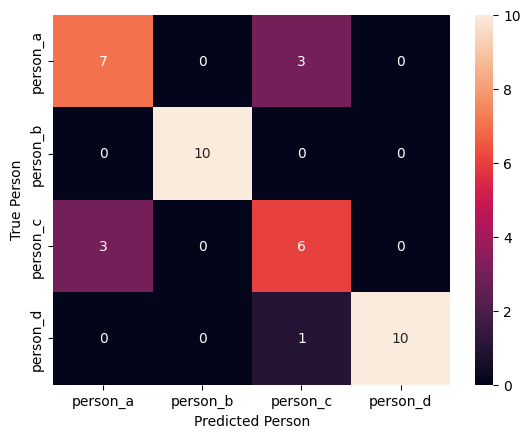

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions_array = np.array(predictions)
true_labels_array = np.array(test_batch[1])

predicted_classes = np.argmax(predictions_array, axis=1)
true_classes = np.argmax(true_labels_array, axis=1)

predicted_labels = np.array(class_labels)[predicted_classes]
true_labels = np.array(class_labels)[true_classes]


cm = confusion_matrix(predicted_labels, true_labels, labels = class_labels)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
# Add labels to the axes
plt.xlabel('Predicted Person')
plt.ylabel('True Person')

# Show the plot
plt.show()